Shape von X_train_windows vor Anpassung: (718, 130, 12)
Shape von X_train_windows nach Anpassung: (718, 130, 12)
Epoch 1/100
23/23 [==============================] - 10s 255ms/step - loss: 1.5926 - accuracy: 0.2953 - val_loss: 1.6006 - val_accuracy: 0.2439
Epoch 2/100
23/23 [==============================] - 6s 252ms/step - loss: 1.5892 - accuracy: 0.3050 - val_loss: 1.6075 - val_accuracy: 0.2439
Epoch 3/100
23/23 [==============================] - 5s 239ms/step - loss: 1.5813 - accuracy: 0.3050 - val_loss: 1.6054 - val_accuracy: 0.2439
Epoch 4/100
23/23 [==============================] - 7s 317ms/step - loss: 1.5795 - accuracy: 0.3050 - val_loss: 1.6142 - val_accuracy: 0.2439
Epoch 5/100
23/23 [==============================] - 7s 293ms/step - loss: 1.5770 - accuracy: 0.3050 - val_loss: 1.6155 - val_accuracy: 0.2439
Epoch 6/100
23/23 [==============================] - 6s 248ms/step - loss: 1.5800 - accuracy: 0.3050 - val_loss: 1.6194 - val_accuracy: 0.2439
Epoch 7/100
23/23 [=========

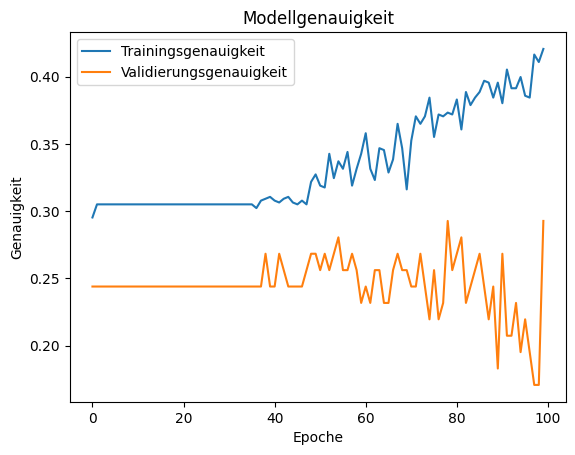

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, Dropout
import matplotlib.pyplot as plt

# Daten einlesen
data = pd.read_csv('final_data_02.csv')
data.describe()
X = data.drop(['Label'], axis=1)
y = data['Label']

def reciprocal(d):

    # Identify numeric columns
    numeric_columns = d.select_dtypes(include=np.number).columns
    
    # Calculate reciprocal values for non-zero elements and replace zeros with a small value (1e-6)
    d[numeric_columns] = np.where(d[numeric_columns] != 0, 1 / d[numeric_columns], 1e-6)
    
    return d

data = reciprocal(data)
data = pd.concat([data, y], axis=1)

# Konvertiere Labels in numerische Werte
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Teile die Daten in Trainings- und Testsets auf
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Sliding Window-Technik
window_size = 130

# Erstelle Sliding Windows für Trainingsdaten
X_train_windows = []
y_train_windows = []
for i in range(len(X_train) - window_size):
    X_train_windows.append(X_train.iloc[i:i+window_size].values.astype('float32'))  # Umwandlung in float32
    y_train_windows.append(y_train[i+window_size])

X_train_windows = np.array(X_train_windows)
y_train_windows = np.array(y_train_windows).astype(int)

# Erstelle Sliding Windows für Testdaten
X_test_windows = []
y_test_windows = []
for i in range(len(X_test) - window_size):
    X_test_windows.append(X_test.iloc[i:i+window_size].values.astype('float32'))  # Umwandlung in float32
    y_test_windows.append(y_test[i+window_size])

X_test_windows = np.array(X_test_windows)
y_test_windows = np.array(y_test_windows).astype(int)


# Überprüfe die Form der Eingabedaten
print("Shape von X_train_windows vor Anpassung:", X_train_windows.shape)

# Passe die Form der Eingabedaten an
X_train_windows = np.reshape(X_train_windows, (X_train_windows.shape[0], X_train_windows.shape[1], X_train_windows.shape[2]))

# Überprüfe erneut die Form der Eingabedaten
print("Shape von X_train_windows nach Anpassung:", X_train_windows.shape)

# LSTM-Modell
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train_windows.shape[1], X_train_windows.shape[2])))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Kompiliere das Modell
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Trainiere das Modell
history = model.fit(X_train_windows, y_train_windows, epochs=100, batch_size=32, validation_data=(X_test_windows, y_test_windows))

# Überprüfe die Form der Testdaten
print("Shape von X_test_windows vor Anpassung:", X_test_windows.shape)

# Passe die Form der Testdaten an
X_test_windows = np.reshape(X_test_windows, (X_test_windows.shape[0], X_test_windows.shape[1], X_test_windows.shape[2]))

# Überprüfe erneut die Form der Testdaten
print("Shape von X_test_windows nach Anpassung:", X_test_windows.shape)

# Evaluieren des Modells
y_pred = model.predict(X_test_windows)
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_labels)

# Konvertiere vorhergesagte Labels in Label-Strings
y_test_labels = label_encoder.inverse_transform(y_test_windows)

# Berechne die Genauigkeit
accuracy = accuracy_score(y_test_labels, y_pred_labels)

# Gib jedes Element der vorhergesagten und tatsächlichen Labels aus
for pred_label, true_label in zip(y_pred_labels, y_test_labels):
    print("Predicted Label:", pred_label)
    print("True Label:", true_label)
    print("------------------------------------------------------")

print("Accuracy:", accuracy)

# Plot der Trainings- und Validierungsgenauigkeit
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modellgenauigkeit')
plt.ylabel('Genauigkeit')
plt.xlabel('Epoche')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
